In [2]:
!pip install plotly dnspython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 3.9 MB/s eta 0:00:00a 0:00:01


In [ ]:
# Cell 1: Setup and Load Flagged Metadata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from collections import Counter
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import stats
import warnings
import os
from dotenv import load_dotenv
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Malaysian Parliamentary Corpus - Stratified Sampling & Validation")
print("="*70)

# Load flagged metadata from Notebook 1
metadata_df = pd.read_csv('hansard_flagged_metadata.csv')

print(f" Loaded flagged metadata: {len(metadata_df):,} documents")
print(f" Date range: {metadata_df['hansardDate'].min()} to {metadata_df['hansardDate'].max()}")
print(f"  Flagged dimensions: scrapMethod, docLength, decade")

# Quick validation
print(f"\n Quick Overview:")
print(f"   ScrapMethod: {metadata_df['scrapMethod'].value_counts().to_dict()}")
print(f"   DocLength: {metadata_df['docLength'].value_counts().to_dict()}")
print(f"   Decades: {metadata_df['decade'].nunique()} decades covered")

# Connect to MongoDB for sampling
# Load environment variables from the correct .env file
env_path = os.path.join(os.getcwd(), '3_app_system', 'backend', '.env')
load_dotenv(dotenv_path=env_path)

mongo_uri = os.getenv('MONGODB_URI')
if not mongo_uri:
    raise ValueError("MONGODB_URI not found in .env file at 3_app_system/backend/.env")

client = MongoClient(mongo_uri)
db = client['MyParliament']
collection = db['HansardDocument']

print(f" Connected to MongoDB for stratified sampling")

Malaysian Parliamentary Corpus - Stratified Sampling & Validation
 Loaded flagged metadata: 3,816 documents
 Date range: 1959-09-11 00:00:00.000 to 2025-05-05 00:00:00.000
  Flagged dimensions: scrapMethod, docLength, decade

 Quick Overview:
   ScrapMethod: {'tesseract': 1918, 'pdfplumber': 1697, 'googlevision': 201}
   DocLength: {'long': 3767, 'medium': 44, 'short': 5}
   Decades: 8 decades covered
 Connected to MongoDB for stratified sampling


In [3]:
# Cell 2: Execute Stratified Sampling - Core_500 Selection 
from datetime import datetime
import random

print(" Executing Stratified Sampling...")
print("Target: 500 documents across all existing strata")
print("-" * 50)

# Step 1: Get strata information first
print(" Analyzing existing strata...")

strata_pipeline = [
    {'$match': {
        'scrapMethod': {'$exists': True},
        'docLength': {'$exists': True},
        'decade': {'$exists': True}
    }},
    {'$group': {
        '_id': {
            'scrapMethod': '$scrapMethod',
            'docLength': '$docLength',
            'decade': '$decade'
        },
        'count': {'$sum': 1},
        'doc_ids': {'$push': '$_id'}
    }},
    {'$sort': {'count': -1}}
]

strata_info = list(collection.aggregate(strata_pipeline))
total_docs = sum(stratum['count'] for stratum in strata_info)
target_sample = 500

print(f" Found {len(strata_info)} existing strata")
print(f" Total documents: {total_docs:,}")

# Step 2: Calculate proportional sample sizes
sampled_docs = []
sample_log = []

for stratum in strata_info:
    stratum_count = stratum['count']
    stratum_id = stratum['_id']
    doc_ids = stratum['doc_ids']
    
    # Calculate proportional sample size
    proportional_size = max(1, round((stratum_count / total_docs) * target_sample))
    
    # Don't sample more than available
    actual_sample_size = min(proportional_size, stratum_count)
    
    # Random sample from this stratum
    if actual_sample_size < stratum_count:
        sampled_ids = random.sample(doc_ids, actual_sample_size)
    else:
        sampled_ids = doc_ids
    
    sampled_docs.extend(sampled_ids)
    
    # Log sampling details
    sample_log.append({
        'strata': f"{stratum_id['scrapMethod']}-{stratum_id['docLength']}-{stratum_id['decade']}",
        'total': stratum_count,
        'sampled': actual_sample_size,
        'percentage': (actual_sample_size / stratum_count) * 100
    })

# Step 3: Adjust to exactly 500 documents if needed
if len(sampled_docs) > target_sample:
    # Randomly remove excess documents
    sampled_docs = random.sample(sampled_docs, target_sample)
elif len(sampled_docs) < target_sample:
    # Need more documents - sample additional from largest strata
    needed = target_sample - len(sampled_docs)
    largest_strata = sorted(strata_info, key=lambda x: x['count'], reverse=True)
    
    for stratum in largest_strata:
        if needed <= 0:
            break
        
        # Get unsampled docs from this stratum
        unsampled = [doc_id for doc_id in stratum['doc_ids'] if doc_id not in sampled_docs]
        additional = min(needed, len(unsampled))
        
        if additional > 0:
            additional_docs = random.sample(unsampled, additional)
            sampled_docs.extend(additional_docs)
            needed -= additional

print(f" Sampling completed: {len(sampled_docs)} documents selected")

# Step 4: Get full documents and create metadata
print(" Retrieving full document data...")

full_sampled_docs = list(collection.find({'_id': {'$in': sampled_docs}}))

# Flag sampled documents in MongoDB
flag_result = collection.update_many(
    {'_id': {'$in': sampled_docs}},
    {'$set': {
        'sample_group': 'core_500',
        'sampling_timestamp': datetime.now()
    }}
)

print(f"  Flagged {flag_result.modified_count} documents as 'core_500'")

# Create sampled metadata DataFrame
sampled_metadata = pd.DataFrame([
    {
        'document_id': str(doc['_id']),
        'hansardDate': doc['hansardDate'],
        'scrapMethod': doc['scrapMethod'],
        'docLength': doc['docLength'],
        'decade': doc['decade'],
        'wordCount': doc['wordCount']
    }
    for doc in full_sampled_docs
])

# Display sampling summary
print(f"\n Sampling Summary by Strata:")
print("-" * 50)
for log_entry in sample_log[:20]:  
    print(f"   {log_entry['strata']}: {log_entry['sampled']}/{log_entry['total']} ({log_entry['percentage']:.1f}%)")

print(f"\n Core_500 sample ready for analysis")
print(f" Final sample size: {len(sampled_metadata)} documents")

 Executing Stratified Sampling...
Target: 500 documents across all existing strata
--------------------------------------------------
 Analyzing existing strata...
 Found 29 existing strata
 Total documents: 3,816
 Sampling completed: 500 documents selected
 Retrieving full document data...
  Flagged 500 documents as 'core_500'

 Sampling Summary by Strata:
--------------------------------------------------
   pdfplumber-long-2000s: 84/639 (13.1%)
   pdfplumber-long-2010s: 81/615 (13.2%)
   tesseract-long-1990s: 73/559 (13.1%)
   tesseract-long-1980s: 69/526 (13.1%)
   tesseract-long-1970s: 60/457 (13.1%)
   tesseract-long-1960s: 43/331 (13.0%)
   pdfplumber-long-2020s: 39/299 (13.0%)
   pdfplumber-long-1990s: 16/119 (13.4%)
   googlevision-long-1980s: 11/84 (13.1%)
   googlevision-long-1970s: 9/65 (13.8%)
   googlevision-long-1960s: 5/35 (14.3%)
   googlevision-long-1990s: 2/14 (14.3%)
   pdfplumber-medium-2010s: 2/13 (15.4%)
   tesseract-long-1950s: 1/11 (9.1%)
   tesseract-medium-19

In [4]:
# Cell 3: Create Core_500 Collection with Proper Text Field Handling
from bson import ObjectId
from datetime import datetime

print(" Creating Core_500 MongoDB Collection & Splits")
print("="*50)

try:
    # Step 1: Create new hansard_core500 collection
    core500_collection = db['hansard_core500']
    
    # Drop existing collection if it exists
    if 'hansard_core500' in db.list_collection_names():
        core500_collection.drop()
        print("  Dropped existing hansard_core500 collection")
    
    # Convert document IDs back to ObjectIds
    sampled_object_ids = [ObjectId(doc_id) for doc_id in sampled_metadata['document_id']]
    
    # Get full documents from original collection
    print(" Retrieving full documents for core_500...")
    full_sampled_docs = list(collection.find({'_id': {'$in': sampled_object_ids}}))
    
    if len(full_sampled_docs) != len(sampled_metadata):
        print(f"  Document count mismatch: Expected {len(sampled_metadata)}, found {len(full_sampled_docs)}")
        # Try to recover missing documents
        found_ids = [str(doc['_id']) for doc in full_sampled_docs]
        missing_ids = set(sampled_metadata['document_id']) - set(found_ids)
        print(f"  Missing {len(missing_ids)} documents")
        
        # Update sampled_metadata to only include found documents
        sampled_metadata = sampled_metadata[sampled_metadata['document_id'].isin(found_ids)].reset_index(drop=True)
        print(f" Proceeding with {len(sampled_metadata)} confirmed documents")
    
    # Step 2: Enhanced text field processing - prioritize ocr_text over content_text
    print("\n Processing text fields (ocr_text priority)...")
    
    text_stats = {
        'ocr_text_available': 0,
        'content_text_only': 0,
        'both_available': 0,
        'no_text': 0,
        'ocr_text_used': 0,
        'content_text_used': 0
    }
    
    for doc in full_sampled_docs:
        # Check what text fields are available
        has_ocr = 'ocr_text' in doc and doc['ocr_text'] and str(doc['ocr_text']).strip()
        has_content = 'content_text' in doc and doc['content_text'] and str(doc['content_text']).strip()
        
        # Statistics tracking
        if has_ocr and has_content:
            text_stats['both_available'] += 1
        elif has_ocr:
            text_stats['ocr_text_available'] += 1
        elif has_content:
            text_stats['content_text_only'] += 1
        else:
            text_stats['no_text'] += 1
        
        # Prioritize ocr_text, fallback to content_text
        if has_ocr:
            doc['full_text'] = doc['ocr_text']
            doc['text_source'] = 'ocr_text'
            text_stats['ocr_text_used'] += 1
        elif has_content:
            doc['full_text'] = doc['content_text']
            doc['text_source'] = 'content_text'
            text_stats['content_text_used'] += 1
        else:
            doc['full_text'] = ''
            doc['text_source'] = 'none'
        
        # Recalculate word count based on actual text used
        if doc['full_text']:
            import re
            actual_words = len(re.findall(r'\b\w+\b', str(doc['full_text']).lower()))
            doc['actual_word_count'] = actual_words
            
            # Update length category based on actual text
            if actual_words < 2000:
                doc['actual_doc_length'] = 'short'
            elif actual_words <= 10000:
                doc['actual_doc_length'] = 'medium'
            else:
                doc['actual_doc_length'] = 'long'
        else:
            doc['actual_word_count'] = 0
            doc['actual_doc_length'] = 'empty'
    
    # Report text field statistics
    print(f" Text Field Analysis:")
    print(f"   Documents with ocr_text only: {text_stats['ocr_text_available']}")
    print(f"   Documents with content_text only: {text_stats['content_text_only']}")
    print(f"   Documents with both fields: {text_stats['both_available']}")
    print(f"   Documents with no text: {text_stats['no_text']}")
    print(f"   Using ocr_text: {text_stats['ocr_text_used']} ({text_stats['ocr_text_used']/len(full_sampled_docs)*100:.1f}%)")
    print(f"   Using content_text: {text_stats['content_text_used']} ({text_stats['content_text_used']/len(full_sampled_docs)*100:.1f}%)")
    
    # Step 3: Simple random train/test/validation split
    print("\n Creating Train/Test/Validation Splits...")
    print("Using simple random split for reliability")
    
    # Filter out documents with no text for splitting
    valid_docs = [doc for doc in full_sampled_docs if doc['full_text'] and doc['actual_word_count'] > 0]
    empty_docs = [doc for doc in full_sampled_docs if not doc['full_text'] or doc['actual_word_count'] == 0]
    
    if empty_docs:
        print(f"  Excluding {len(empty_docs)} documents with no text from ML splits")
        print(f" Using {len(valid_docs)} documents for train/test/validation")
    
    # Shuffle the valid documents randomly
    import random
    random.seed(42)
    random.shuffle(valid_docs)
    
    n_docs = len(valid_docs)
    
    # Calculate split sizes
    train_size = int(0.70 * n_docs)  # 70% for training
    test_size = int(0.15 * n_docs)   # 15% for testing  
    val_size = n_docs - train_size - test_size  # Remaining for validation
    
    # Create splits
    train_docs = valid_docs[:train_size]
    test_docs = valid_docs[train_size:train_size + test_size]
    val_docs = valid_docs[train_size + test_size:]
    
    print(f" Split Results:")
    print(f"   Training set: {len(train_docs)} documents ({len(train_docs)/n_docs*100:.1f}%)")
    print(f"   Testing set: {len(test_docs)} documents ({len(test_docs)/n_docs*100:.1f}%)")
    print(f"   Validation set: {len(val_docs)} documents ({len(val_docs)/n_docs*100:.1f}%)")
    
    # Step 4: Add split_type to all documents
    print("\n  Adding split labels to documents...")
    
    # Create mapping of document_id to split_type
    split_mapping = {}
    
    for doc in train_docs:
        split_mapping[str(doc['_id'])] = 'train'
    for doc in test_docs:
        split_mapping[str(doc['_id'])] = 'test'
    for doc in val_docs:
        split_mapping[str(doc['_id'])] = 'validation'
    for doc in empty_docs:
        split_mapping[str(doc['_id'])] = 'excluded'  # Mark empty docs as excluded
    
    # Add split_type and timestamps to each document
    for doc in full_sampled_docs:
        doc_id_str = str(doc['_id'])
        doc['split_type'] = split_mapping.get(doc_id_str, 'train')  # Default to train if not found
        doc['core500_timestamp'] = datetime.now()
        doc['text_processing_timestamp'] = datetime.now()
    
    # Step 5: Insert documents into core500 collection
    print(" Inserting documents into hansard_core500...")
    insert_result = core500_collection.insert_many(full_sampled_docs)
    print(f" Inserted {len(insert_result.inserted_ids)} documents into hansard_core500")
    
    # Step 6: Create indexes for efficient querying
    print(" Creating database indexes...")
    index_results = []
    
    try:
        # Compound index for strata querying
        core500_collection.create_index([
            ('scrapMethod', 1), 
            ('docLength', 1), 
            ('decade', 1)
        ], name='strata_compound_idx')
        index_results.append("strata_compound")
    except Exception as e:
        print(f"  Strata index warning: {e}")
    
    try:
        # Index for split type (important for ML pipeline)
        core500_collection.create_index([('split_type', 1)], name='split_type_idx')
        index_results.append("split_type")
    except Exception as e:
        print(f"  Split type index warning: {e}")
    
    try:
        # Index for text source analysis
        core500_collection.create_index([('text_source', 1)], name='text_source_idx')
        index_results.append("text_source")
    except Exception as e:
        print(f"  Text source index warning: {e}")
    
    try:
        # Index for actual word count (for filtering)
        core500_collection.create_index([('actual_word_count', 1)], name='word_count_idx')
        index_results.append("word_count")
    except Exception as e:
        print(f"  Word count index warning: {e}")
    
    try:
        # Index for date-based queries
        core500_collection.create_index([('hansardDate', 1)], name='date_idx')
        index_results.append("hansardDate")
    except Exception as e:
        print(f"  Date index warning: {e}")
    
    print(f" Created indexes: {', '.join(index_results)}")
    
    # Step 7: Update sampled_metadata with enhanced information
    print("\n Updating metadata with enhanced information...")
    
    # Create enhanced metadata with actual text information
    enhanced_metadata = []
    for doc in full_sampled_docs:
        enhanced_metadata.append({
            'document_id': str(doc['_id']),
            'hansardDate': doc['hansardDate'],
            'scrapMethod': doc['scrapMethod'],
            'docLength': doc['docLength'],
            'decade': doc['decade'],
            'wordCount': doc.get('wordCount', 0),
            'actual_word_count': doc.get('actual_word_count', 0),
            'actual_doc_length': doc.get('actual_doc_length', 'unknown'),
            'text_source': doc.get('text_source', 'unknown'),
            'split_type': doc.get('split_type', 'unknown'),
            'year': pd.to_datetime(doc['hansardDate']).year if 'hansardDate' in doc else None
        })
    
    # Update sampled_metadata DataFrame
    sampled_metadata = pd.DataFrame(enhanced_metadata)
    
    # Verify split distribution
    print(f"\n Split Distribution Verification:")
    split_summary = sampled_metadata['split_type'].value_counts()
    for split_name, count in split_summary.items():
        percentage = (count / len(sampled_metadata)) * 100
        print(f"   {split_name.capitalize()}: {count} documents ({percentage:.1f}%)")
    
    # Text source distribution
    print(f"\n Text Source Distribution:")
    text_source_summary = sampled_metadata['text_source'].value_counts()
    for source, count in text_source_summary.items():
        percentage = (count / len(sampled_metadata)) * 100
        print(f"   {source}: {count} documents ({percentage:.1f}%)")
    
    # Actual vs original word count comparison
    if 'wordCount' in sampled_metadata.columns and 'actual_word_count' in sampled_metadata.columns:
        valid_comparisons = sampled_metadata[
            (sampled_metadata['wordCount'] > 0) & 
            (sampled_metadata['actual_word_count'] > 0)
        ]
        
        if len(valid_comparisons) > 0:
            word_count_diff = (valid_comparisons['actual_word_count'] - valid_comparisons['wordCount']).abs()
            avg_diff = word_count_diff.mean()
            print(f"\n Word Count Accuracy:")
            print(f"   Average difference between original and actual: {avg_diff:.1f} words")
            print(f"   Documents with significant difference (>1000 words): {(word_count_diff > 1000).sum()}")
    
    # Step 8: Validate collection creation
    print(f"\n Collection Validation:")
    
    # Count documents by split in MongoDB
    train_count = core500_collection.count_documents({'split_type': 'train'})
    test_count = core500_collection.count_documents({'split_type': 'test'})
    val_count = core500_collection.count_documents({'split_type': 'validation'})
    excluded_count = core500_collection.count_documents({'split_type': 'excluded'})
    total_count = core500_collection.count_documents({})
    
    print(f"   MongoDB counts:")
    print(f"     Train: {train_count}, Test: {test_count}, Validation: {val_count}")
    print(f"     Excluded (no text): {excluded_count}")
    print(f"     Total in collection: {total_count}")
    print(f"     Expected total: {len(sampled_metadata)}")
    
    if total_count == len(sampled_metadata):
        print(" Collection created successfully - counts match!")
    else:
        print(f"  Count mismatch - investigating...")
    
    # Test query functionality with text fields
    sample_train_doc = core500_collection.find_one({'split_type': 'train', 'actual_word_count': {'$gt': 0}})
    if sample_train_doc:
        print(" Query functionality verified")
        print(f"   Sample train document:")
        print(f"     Text source: {sample_train_doc.get('text_source', 'unknown')}")
        print(f"     Actual word count: {sample_train_doc.get('actual_word_count', 0)}")
        print(f"     Full text preview: {str(sample_train_doc.get('full_text', ''))[:100]}...")
    
    success = True
    
except Exception as e:
    print(f" Error creating core500 collection: {e}")
    import traceback
    traceback.print_exc()
    success = False

if success:
    print(f"\n CORE_500 COLLECTION READY!")
    print("="*50)
    print(f" Collection: hansard_core500 ({total_count} documents)")
    print(f" Text processing: ocr_text prioritized over content_text")
    print(f" Train/Test/Validation splits: {train_count}/{test_count}/{val_count}")
    print(f" Excluded documents (no text): {excluded_count}")
    print(f" Database indexes created")
    print(f" Enhanced metadata with actual word counts")
    print(f" Ready for ML pipeline development")
else:
    print(f"\n COLLECTION CREATION FAILED")
    print("="*50)
    print(f"  Check error messages above")
    print(f"  May need to debug MongoDB connection or data issues")

 Creating Core_500 MongoDB Collection & Splits
 Retrieving full documents for core_500...

 Processing text fields (ocr_text priority)...
 Text Field Analysis:
   Documents with ocr_text only: 2
   Documents with content_text only: 218
   Documents with both fields: 280
   Documents with no text: 0
   Using ocr_text: 282 (56.4%)
   Using content_text: 218 (43.6%)

 Creating Train/Test/Validation Splits...
Using simple random split for reliability
 Split Results:
   Training set: 350 documents (70.0%)
   Testing set: 75 documents (15.0%)
   Validation set: 75 documents (15.0%)

  Adding split labels to documents...
 Inserting documents into hansard_core500...
 Inserted 500 documents into hansard_core500
 Creating database indexes...
 Created indexes: strata_compound, split_type, text_source, word_count, hansardDate

 Updating metadata with enhanced information...

 Split Distribution Verification:
   Train: 350 documents (70.0%)
   Validation: 75 documents (15.0%)
   Test: 75 documents 

## Post-sampling EDA

 Post-Sampling EDA - Representativeness Check


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


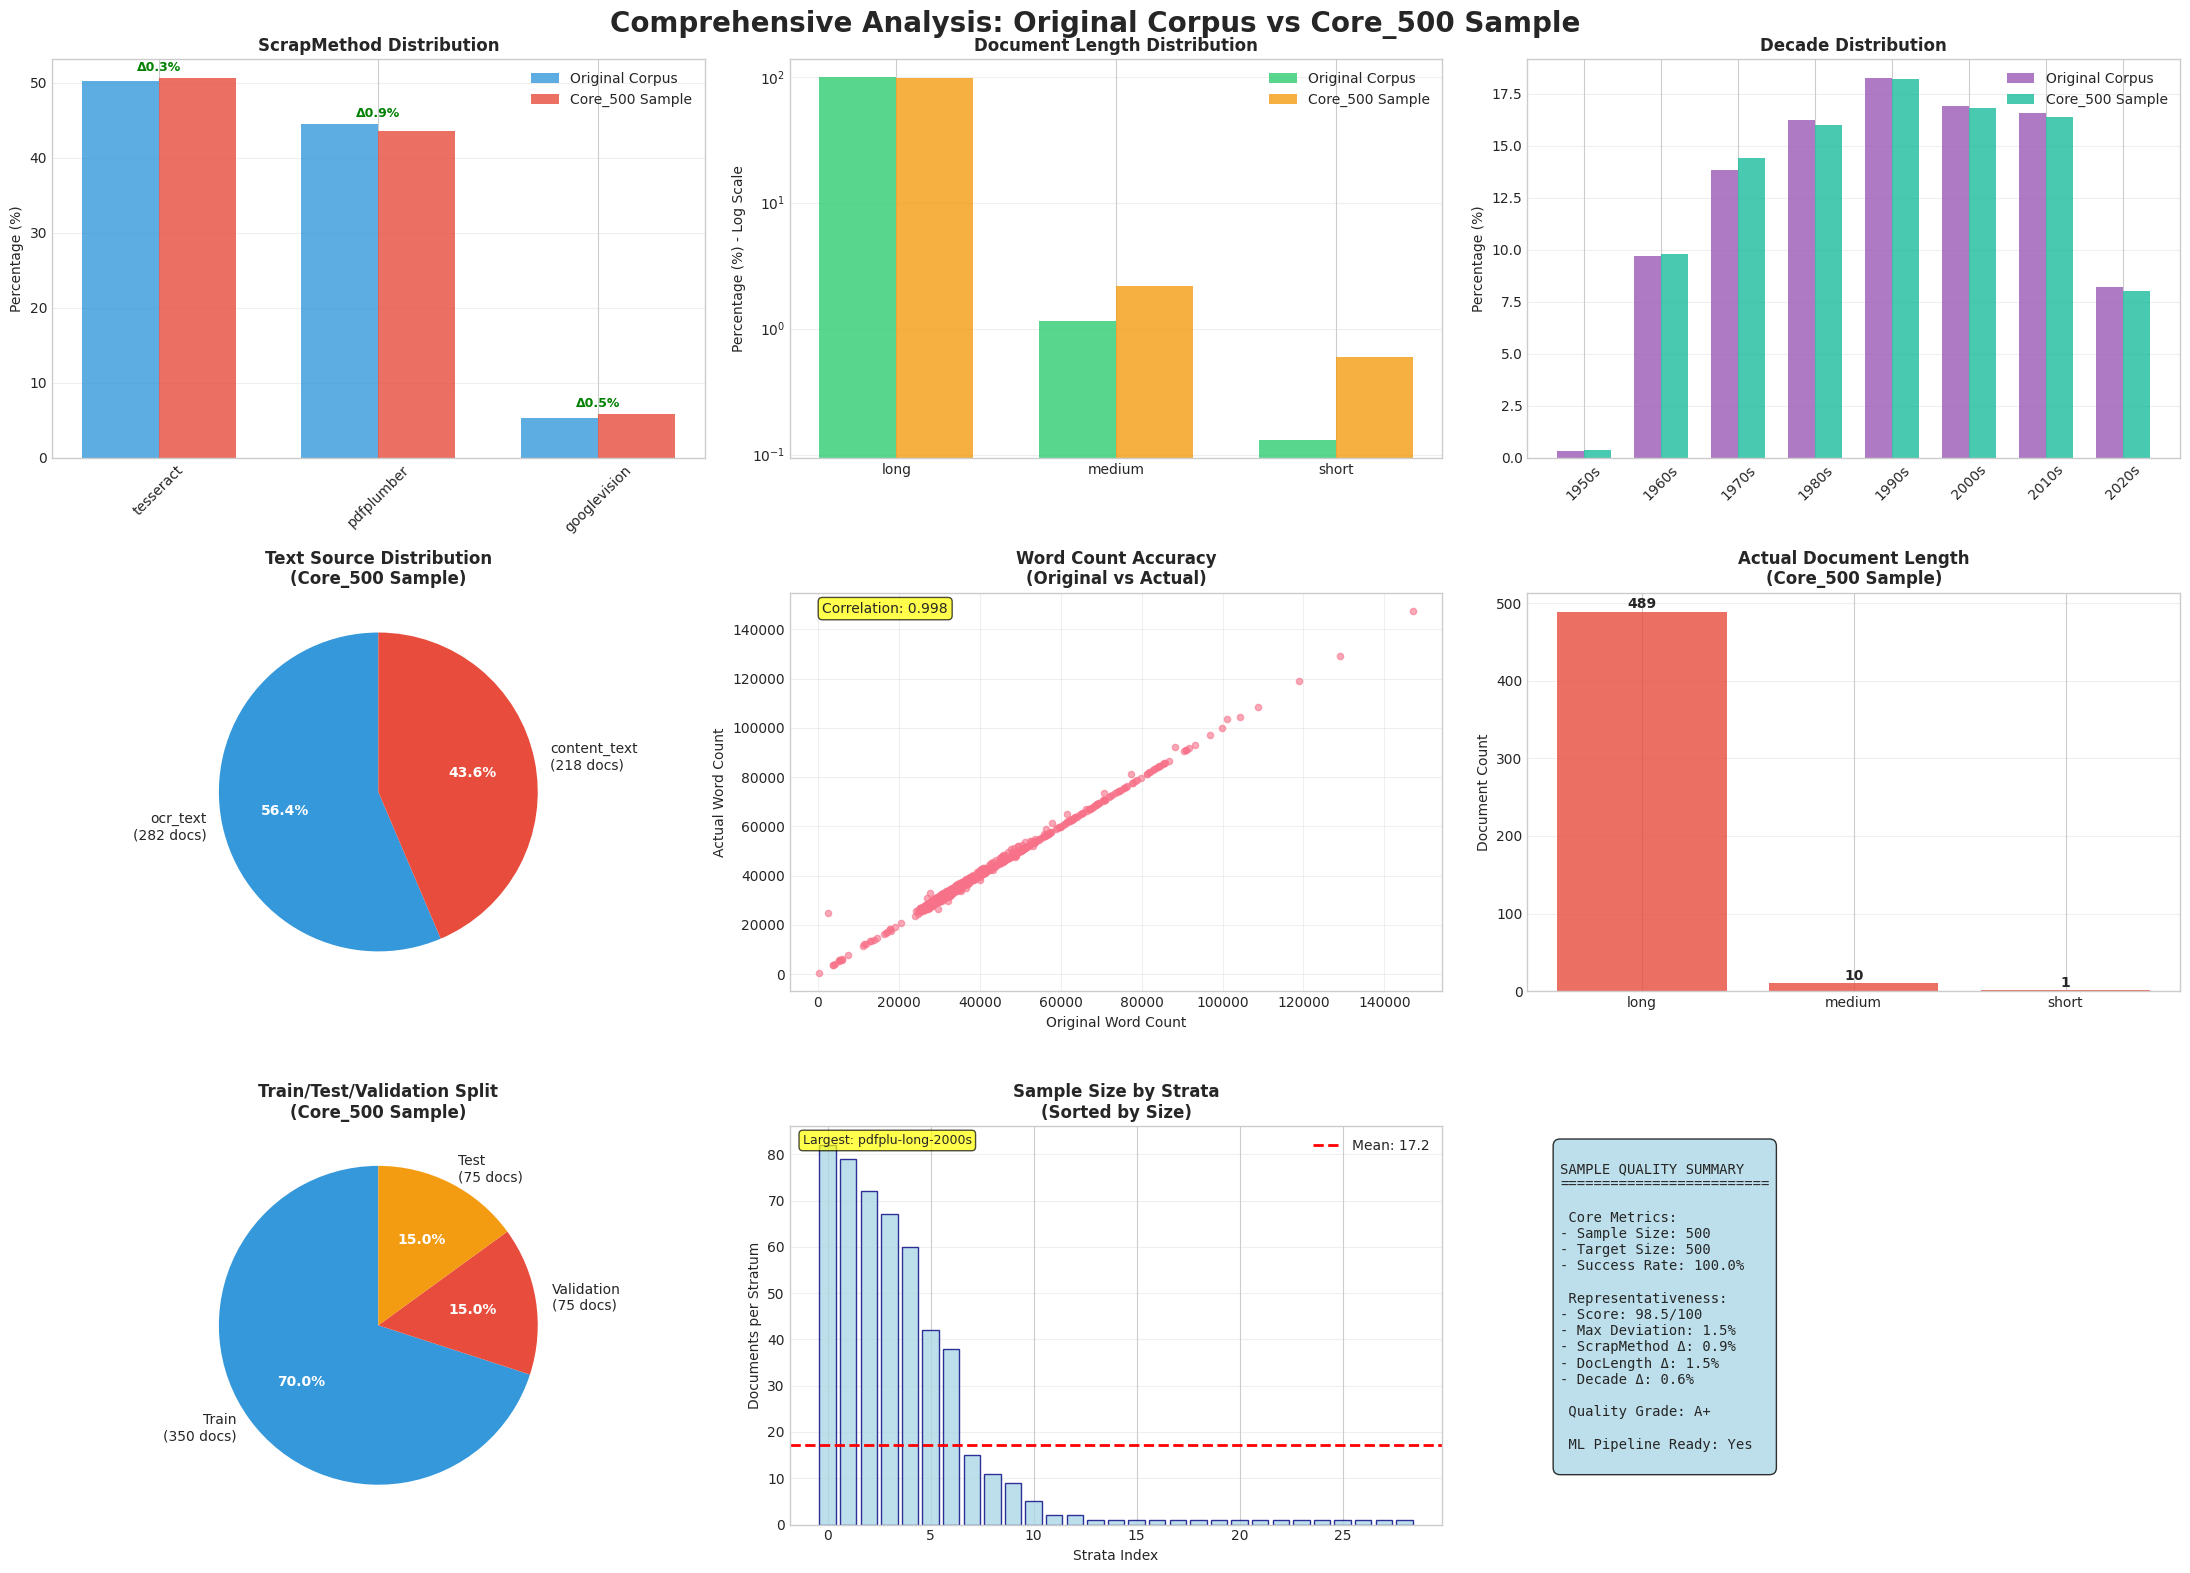


 Comprehensive Distribution Analysis:
ScrapMethod  | Max:   0.9% | Mean:   0.6% |  Excellent
DocLength    | Max:   1.5% | Mean:   1.0% |  Excellent
Decade       | Max:   0.6% | Mean:   0.2% |  Excellent

 Text Quality Analysis:
------------------------------
   ocr_text     | 282 docs ( 56.4%)
   content_text | 218 docs ( 43.6%)
 Representativeness analysis completed


In [22]:
# Cell 4: Post-Sampling EDA - Representativeness Analysis 
print(" Post-Sampling EDA - Representativeness Check")
print("="*55)

# Enhanced comparison with text quality analysis
fig, axes = plt.subplots(3, 3, figsize=(22, 16))
fig.suptitle('Comprehensive Analysis: Original Corpus vs Core_500 Sample', 
             fontsize=20, fontweight='bold', y=0.98)

# Helper functions
def safe_percentage_calc(series, total):
    """Safely calculate percentages"""
    return (series / total * 100).fillna(0)

def align_distributions(orig_series, samp_series):
    """Align two value_counts series for comparison"""
    all_categories = orig_series.index.union(samp_series.index)
    orig_aligned = orig_series.reindex(all_categories, fill_value=0)
    samp_aligned = samp_series.reindex(all_categories, fill_value=0)
    return orig_aligned, samp_aligned

# Prepare comparison data
original_scrap_counts = metadata_df['scrapMethod'].value_counts()
sample_scrap_counts = sampled_metadata['scrapMethod'].value_counts()

original_length_counts = metadata_df['docLength'].value_counts()
sample_length_counts = sampled_metadata['docLength'].value_counts()

original_decade_counts = metadata_df['decade'].value_counts().sort_index()
sample_decade_counts = sampled_metadata['decade'].value_counts().sort_index()

# Convert to percentages
original_scrap = safe_percentage_calc(original_scrap_counts, len(metadata_df))
sample_scrap = safe_percentage_calc(sample_scrap_counts, len(sampled_metadata))

original_length = safe_percentage_calc(original_length_counts, len(metadata_df))
sample_length = safe_percentage_calc(sample_length_counts, len(sampled_metadata))

original_decade = safe_percentage_calc(original_decade_counts, len(metadata_df))
sample_decade = safe_percentage_calc(sample_decade_counts, len(sampled_metadata))

# Row 1: Traditional distribution comparisons
width = 0.35

# 1.1 ScrapMethod comparison
ax1 = axes[0, 0]
orig_scrap_aligned, samp_scrap_aligned = align_distributions(original_scrap, sample_scrap)
x_pos = np.arange(len(orig_scrap_aligned))

bars1 = ax1.bar(x_pos - width/2, orig_scrap_aligned.values, width, 
                label='Original Corpus', alpha=0.8, color='#3498db')
bars2 = ax1.bar(x_pos + width/2, samp_scrap_aligned.values, width,
                label='Core_500 Sample', alpha=0.8, color='#e74c3c')

ax1.set_title('ScrapMethod Distribution', fontweight='bold', fontsize=12)
ax1.set_ylabel('Percentage (%)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(orig_scrap_aligned.index, rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add difference annotations
for i, (orig, samp) in enumerate(zip(orig_scrap_aligned.values, samp_scrap_aligned.values)):
    diff = abs(orig - samp)
    color = 'green' if diff <= 3 else 'orange' if diff <= 5 else 'red'
    ax1.annotate(f'Δ{diff:.1f}%', xy=(i, max(orig, samp) + 1), 
                ha='center', fontsize=9, color=color, fontweight='bold')

# 1.2 DocLength comparison
ax2 = axes[0, 1]
orig_length_aligned, samp_length_aligned = align_distributions(original_length, sample_length)
x_pos = np.arange(len(orig_length_aligned))

bars3 = ax2.bar(x_pos - width/2, orig_length_aligned.values, width, 
                label='Original Corpus', alpha=0.8, color='#2ecc71')
bars4 = ax2.bar(x_pos + width/2, samp_length_aligned.values, width,
                label='Core_500 Sample', alpha=0.8, color='#f39c12')

ax2.set_title('Document Length Distribution', fontweight='bold', fontsize=12)
ax2.set_ylabel('Percentage (%) - Log Scale')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(orig_length_aligned.index)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_yscale('log')  # Log scale due to extreme skew

# 1.3 Decade comparison
ax3 = axes[0, 2]
orig_decade_aligned, samp_decade_aligned = align_distributions(original_decade, sample_decade)
x_pos = np.arange(len(orig_decade_aligned))

bars5 = ax3.bar(x_pos - width/2, orig_decade_aligned.values, width, 
                label='Original Corpus', alpha=0.8, color='#9b59b6')
bars6 = ax3.bar(x_pos + width/2, samp_decade_aligned.values, width,
                label='Core_500 Sample', alpha=0.8, color='#1abc9c')

ax3.set_title('Decade Distribution', fontweight='bold', fontsize=12)
ax3.set_ylabel('Percentage (%)')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(orig_decade_aligned.index, rotation=45)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Row 2: Text quality and word count analysis
# 2.1 Text source distribution (new analysis)
ax4 = axes[1, 0]
if 'text_source' in sampled_metadata.columns:
    text_source_counts = sampled_metadata['text_source'].value_counts()
    colors_text = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71']
    
    wedges, texts, autotexts = ax4.pie(text_source_counts.values, 
                                      labels=[f'{label}\n({count} docs)' for label, count in text_source_counts.items()], 
                                      autopct='%1.1f%%', 
                                      colors=colors_text[:len(text_source_counts)],
                                      startangle=90)
    ax4.set_title('Text Source Distribution\n(Core_500 Sample)', fontweight='bold', fontsize=12)
    
    # Enhance text readability
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
else:
    ax4.text(0.5, 0.5, 'Text source data\nnot available', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Text Source Distribution', fontweight='bold', fontsize=12)

# 2.2 Word count comparison (original vs actual)
ax5 = axes[1, 1]
if 'actual_word_count' in sampled_metadata.columns:
    # Compare original wordCount vs actual_word_count
    valid_comparisons = sampled_metadata[
        (sampled_metadata['wordCount'] > 0) & 
        (sampled_metadata['actual_word_count'] > 0)
    ]
    
    if len(valid_comparisons) > 0:
        ax5.scatter(valid_comparisons['wordCount'], valid_comparisons['actual_word_count'], 
                   alpha=0.6, s=20)
        
        # Add diagonal line (perfect match)
        max_val = max(valid_comparisons['wordCount'].max(), valid_comparisons['actual_word_count'].max())
        
        ax5.set_xlabel('Original Word Count')
        ax5.set_ylabel('Actual Word Count')
        ax5.set_title('Word Count Accuracy\n(Original vs Actual)', fontweight='bold', fontsize=12)
        ax5.legend()
        ax5.grid(alpha=0.3)
        
        # Calculate correlation
        correlation = valid_comparisons['wordCount'].corr(valid_comparisons['actual_word_count'])
        ax5.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax5.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    else:
        ax5.text(0.5, 0.5, 'No valid word count\ncomparisons available', 
                ha='center', va='center', transform=ax5.transAxes, fontsize=12)
else:
    # Fallback to regular word count distribution
    orig_word_sample = metadata_df['wordCount'].sample(min(1000, len(metadata_df)), random_state=42)
    samp_word_sample = sampled_metadata['wordCount'].sample(min(500, len(sampled_metadata)), random_state=42)
    
    ax5.hist(orig_word_sample, bins=40, alpha=0.6, label='Original Corpus', 
             density=True, color='#3498db')
    ax5.hist(samp_word_sample, bins=25, alpha=0.8, label='Core_500 Sample', 
             density=True, color='#e74c3c')
    
    ax5.set_xlabel('Words per Document')
    ax5.set_ylabel('Density')
    ax5.set_title('Word Count Distribution', fontweight='bold', fontsize=12)
    ax5.legend()
    ax5.grid(alpha=0.3)

# 2.3 Actual document length distribution (recalculated)
ax6 = axes[1, 2]
if 'actual_doc_length' in sampled_metadata.columns:
    actual_length_counts = sampled_metadata['actual_doc_length'].value_counts()
    
    # Compare with original if possible
    original_for_sample = metadata_df[metadata_df['document_id'].isin(sampled_metadata['document_id'])] if 'document_id' in metadata_df.columns else metadata_df.sample(len(sampled_metadata), random_state=42)
    
    x_pos = np.arange(len(actual_length_counts))
    bars_actual = ax6.bar(x_pos, actual_length_counts.values, alpha=0.8, 
                         color='#e74c3c', label='Actual (Core_500)')
    
    ax6.set_title('Actual Document Length\n(Core_500 Sample)', fontweight='bold', fontsize=12)
    ax6.set_ylabel('Document Count')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels(actual_length_counts.index)
    ax6.grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for bar, count in zip(bars_actual, actual_length_counts.values):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}', ha='center', va='bottom', fontweight='bold')
else:
    ax6.text(0.5, 0.5, 'Actual document length\ndata not available', 
            ha='center', va='center', transform=ax6.transAxes, fontsize=12)

# Row 3: Split analysis and strata coverage
# 3.1 Split distribution with quality metrics
ax7 = axes[2, 0]
if 'split_type' in sampled_metadata.columns:
    split_counts = sampled_metadata['split_type'].value_counts()
    colors_split = ['#3498db', '#e74c3c', '#f39c12', '#95a5a6']
    
    wedges, texts, autotexts = ax7.pie(split_counts.values, 
                                      labels=[f'{label.title()}\n({count} docs)' for label, count in split_counts.items()], 
                                      autopct='%1.1f%%', 
                                      colors=colors_split[:len(split_counts)],
                                      startangle=90)
    ax7.set_title('Train/Test/Validation Split\n(Core_500 Sample)', fontweight='bold', fontsize=12)
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
else:
    ax7.text(0.5, 0.5, 'Split data\nnot available', ha='center', va='center', 
             transform=ax7.transAxes, fontsize=12)

# 3.2 Sample size by strata
ax8 = axes[2, 1]
strata_counts = sampled_metadata.groupby(['scrapMethod', 'docLength', 'decade']).size().sort_values(ascending=False)

if len(strata_counts) > 0:
    bars = ax8.bar(range(len(strata_counts)), strata_counts.values, 
                   color='lightblue', alpha=0.8, edgecolor='navy')
    ax8.set_title('Sample Size by Strata\n(Sorted by Size)', fontweight='bold', fontsize=12)
    ax8.set_xlabel('Strata Index')
    ax8.set_ylabel('Documents per Stratum')
    ax8.grid(axis='y', alpha=0.3)
    
    # Add mean line
    mean_size = strata_counts.mean()
    ax8.axhline(y=mean_size, color='red', linestyle='--', linewidth=2,
               label=f'Mean: {mean_size:.1f}')
    ax8.legend()
    
    # Show largest strata info
    if len(strata_counts) > 0:
        largest_stratum = strata_counts.index[0]
        ax8.text(0.02, 0.98, f'Largest: {largest_stratum[0][:6]}-{largest_stratum[1]}-{largest_stratum[2]}', 
                transform=ax8.transAxes, va='top', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
else:
    ax8.text(0.5, 0.5, 'No strata data\navailable', ha='center', va='center', 
             transform=ax8.transAxes, fontsize=12)

# 3.3 Quality summary dashboard
ax9 = axes[2, 2]
ax9.axis('off')  # Remove axes for text summary

# Calculate key metrics for summary
if len(orig_scrap_aligned) > 0 and len(samp_scrap_aligned) > 0:
    scrap_max_diff = abs(orig_scrap_aligned - samp_scrap_aligned).max()
else:
    scrap_max_diff = 0

if len(orig_length_aligned) > 0 and len(samp_length_aligned) > 0:
    length_max_diff = abs(orig_length_aligned - samp_length_aligned).max()
else:
    length_max_diff = 0

if len(orig_decade_aligned) > 0 and len(samp_decade_aligned) > 0:
    decade_max_diff = abs(orig_decade_aligned - samp_decade_aligned).max()
else:
    decade_max_diff = 0

overall_max_diff = max(scrap_max_diff, length_max_diff, decade_max_diff)
repr_score = max(0, 100 - overall_max_diff)

# Quality summary text
summary_text = f"""
SAMPLE QUALITY SUMMARY
{'='*25}

 Core Metrics:
- Sample Size: {len(sampled_metadata)}
- Target Size: 500
- Success Rate: {len(sampled_metadata)/500*100:.1f}%

 Representativeness:
- Score: {repr_score:.1f}/100
- Max Deviation: {overall_max_diff:.1f}%
- ScrapMethod Δ: {scrap_max_diff:.1f}%
- DocLength Δ: {length_max_diff:.1f}%
- Decade Δ: {decade_max_diff:.1f}%

 Quality Grade: {'A+' if repr_score >= 95 else 'A' if repr_score >= 90 else 'B+' if repr_score >= 85 else 'B' if repr_score >= 80 else 'C'}

 ML Pipeline Ready: {'Yes' if repr_score >= 80 else 'Review Needed'}
"""

ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

plt.tight_layout()
plt.show()

# Enhanced summary statistics
print(f"\n Comprehensive Distribution Analysis:")
print("="*50)

dimensions = [
    ('ScrapMethod', orig_scrap_aligned, samp_scrap_aligned),
    ('DocLength', orig_length_aligned, samp_length_aligned), 
    ('Decade', orig_decade_aligned, samp_decade_aligned)
]

for dim_name, orig_dist, samp_dist in dimensions:
    if len(orig_dist) > 0 and len(samp_dist) > 0:
        max_diff = abs(orig_dist - samp_dist).max()
        mean_diff = abs(orig_dist - samp_dist).mean()
        status = " Excellent" if max_diff <= 3 else " Good" if max_diff <= 5 else " Moderate" if max_diff <= 10 else " Poor"
        print(f"{dim_name:12} | Max: {max_diff:5.1f}% | Mean: {mean_diff:5.1f}% | {status}")
    else:
        print(f"{dim_name:12} | Data insufficient for comparison")

# Text quality summary
if 'text_source' in sampled_metadata.columns:
    print(f"\n Text Quality Analysis:")
    print("-" * 30)
    text_summary = sampled_metadata['text_source'].value_counts()
    for source, count in text_summary.items():
        percentage = count / len(sampled_metadata) * 100
        print(f"   {source:12} | {count:3d} docs ({percentage:5.1f}%)")

print(" Representativeness analysis completed")

In [23]:
# Cell 5: Enhanced Statistical Validation & Sample Quality Metrics (REFINED)
print(" Statistical Validation of Sample Quality")
print("="*45)

# Enhanced statistical testing with comprehensive error handling
def comprehensive_chi_square_test(original_counts, sample_counts, dimension_name):
    """Comprehensive chi-square test with detailed diagnostics"""
    try:
        # Ensure we have data
        if len(original_counts) == 0 or len(sample_counts) == 0:
            return None, None, f"No data available for {dimension_name}"
        
        # Align categories
        all_categories = original_counts.index.union(sample_counts.index)
        orig_aligned = original_counts.reindex(all_categories, fill_value=0)
        samp_aligned = sample_counts.reindex(all_categories, fill_value=0)
        
        # Remove categories with zero counts in original
        non_zero_mask = orig_aligned > 0
        orig_filtered = orig_aligned[non_zero_mask]
        samp_filtered = samp_aligned[non_zero_mask]
        
        if len(orig_filtered) < 2:
            return None, None, f"Insufficient categories for {dimension_name} (need ≥2, got {len(orig_filtered)})"
        
        # Calculate expected frequencies for sample
        total_orig = orig_filtered.sum()
        total_samp = samp_filtered.sum()
        
        if total_samp == 0:
            return None, None, f"No sample data for {dimension_name}"
        
        expected_sample = (orig_filtered / total_orig) * total_samp
        
        # Check if expected frequencies are sufficient (≥5 for reliable chi-square)
        low_expected = (expected_sample < 5).sum()
        if low_expected > 0:
            return None, None, f"Expected frequencies too low for {dimension_name} ({low_expected}/{len(expected_sample)} < 5)"
        
        # Perform chi-square goodness of fit test
        chi2_stat, p_value = stats.chisquare(samp_filtered, expected_sample)
        
        # Calculate effect size (Cramér's V approximation)
        cramers_v = np.sqrt(chi2_stat / (total_samp * (len(orig_filtered) - 1)))
        
        return chi2_stat, p_value, f"Success (Cramér's V: {cramers_v:.3f})"
        
    except Exception as e:
        return None, None, f"Test failed for {dimension_name}: {str(e)}"

# Enhanced independence tests
print(" Statistical Test Results:")
print("-" * 50)

test_results = {}

# Test 1: ScrapMethod distribution
scrap_chi2, scrap_p, scrap_status = comprehensive_chi_square_test(
    original_scrap_counts, sample_scrap_counts, 'ScrapMethod'
)

test_results['scrapMethod'] = {
    'chi2': scrap_chi2, 'p_value': scrap_p, 'status': scrap_status
}

if scrap_chi2 is not None:
    significance = " Representative" if scrap_p > 0.05 else " Differs significantly"
    effect_size = "Small effect" if scrap_chi2 < 5 else "Medium effect" if scrap_chi2 < 15 else "Large effect"
    print(f"ScrapMethod Distribution:")
    print(f"   Chi²: {scrap_chi2:.3f}, p-value: {scrap_p:.4f}")
    print(f"   Result: {significance} ({effect_size})")
else:
    print(f"ScrapMethod Distribution: {scrap_status}")

# Test 2: DocLength distribution  
length_chi2, length_p, length_status = comprehensive_chi_square_test(
    original_length_counts, sample_length_counts, 'DocLength'
)

test_results['docLength'] = {
    'chi2': length_chi2, 'p_value': length_p, 'status': length_status
}

if length_chi2 is not None:
    significance = " Representative" if length_p > 0.05 else " Differs significantly"
    effect_size = "Small effect" if length_chi2 < 5 else "Medium effect" if length_chi2 < 15 else "Large effect"
    print(f"\nDocLength Distribution:")
    print(f"   Chi²: {length_chi2:.3f}, p-value: {length_p:.4f}")
    print(f"   Result: {significance} ({effect_size})")
else:
    print(f"\nDocLength Distribution: {length_status}")

# Test 3: Decade distribution
decade_chi2, decade_p, decade_status = comprehensive_chi_square_test(
    original_decade_counts, sample_decade_counts, 'Decade'
)

test_results['decade'] = {
    'chi2': decade_chi2, 'p_value': decade_p, 'status': decade_status
}

if decade_chi2 is not None:
    significance = " Representative" if decade_p > 0.05 else " Differs significantly"
    effect_size = "Small effect" if decade_chi2 < 5 else "Medium effect" if decade_chi2 < 15 else "Large effect"
    print(f"\nDecade Distribution:")
    print(f"   Chi²: {decade_chi2:.3f}, p-value: {decade_p:.4f}")
    print(f"   Result: {significance} ({effect_size})")
else:
    print(f"\nDecade Distribution: {decade_status}")

# Test 4: Enhanced word count comparison
print(f"\nWord Count Analysis:")
try:
    # Use actual word counts if available, otherwise original
    if 'actual_word_count' in sampled_metadata.columns:
        sample_words = sampled_metadata['actual_word_count'].dropna()
        sample_words = sample_words[sample_words > 0]  # Remove zero counts
    else:
        sample_words = sampled_metadata['wordCount'].dropna()
        sample_words = sample_words[sample_words > 0]
    
    # Sample from original to match size and avoid memory issues
    orig_words = metadata_df['wordCount'].dropna()
    orig_words = orig_words[orig_words > 0]
    
    if len(orig_words) > 1000:
        orig_words_sample = orig_words.sample(1000, random_state=42)
    else:
        orig_words_sample = orig_words
    
    if len(sample_words) > 0 and len(orig_words_sample) > 0:
        # Two-sample t-test
        word_tstat, word_p = stats.ttest_ind(orig_words_sample, sample_words)
        
        # Mann-Whitney U test (non-parametric alternative)
        word_u_stat, word_u_p = stats.mannwhitneyu(orig_words_sample, sample_words, 
                                                   alternative='two-sided')
        
        # Calculate descriptive statistics
        orig_mean = orig_words_sample.mean()
        sample_mean = sample_words.mean()
        orig_median = orig_words_sample.median()
        sample_median = sample_words.median()
        
        print(f"   Parametric (t-test):")
        print(f"     T-statistic: {word_tstat:.3f}, p-value: {word_p:.4f}")
        print(f"     {' Means not significantly different' if word_p > 0.05 else ' Means differ significantly'}")
        
        print(f"   Non-parametric (Mann-Whitney U):")
        print(f"     U-statistic: {word_u_stat:.0f}, p-value: {word_u_p:.4f}")
        print(f"     {' Distributions similar' if word_u_p > 0.05 else ' Distributions differ'}")
        
        print(f"   Descriptive Statistics:")
        print(f"     Original: Mean={orig_mean:,.0f}, Median={orig_median:,.0f}")
        print(f"     Sample:   Mean={sample_mean:,.0f}, Median={sample_median:,.0f}")
        print(f"     Difference: {abs(orig_mean - sample_mean):,.0f} words ({abs(orig_mean - sample_mean)/orig_mean*100:.1f}%)")
        
        test_results['wordCount'] = {
            't_stat': word_tstat, 't_p': word_p,
            'u_stat': word_u_stat, 'u_p': word_u_p,
            'orig_mean': orig_mean, 'sample_mean': sample_mean
        }
    else:
        print("   Insufficient word count data for comparison")
        test_results['wordCount'] = {'status': 'insufficient_data'}
        
except Exception as e:
    print(f"   Word count test failed: {str(e)}")
    test_results['wordCount'] = {'status': f'failed: {str(e)}'}

# Comprehensive quality assessment
def calculate_comprehensive_quality():
    """Calculate comprehensive sample quality metrics"""
    
    quality_metrics = {}
    
    # 1. Representativeness scores by dimension
    repr_scores = []
    
    if len(orig_scrap_aligned) > 0 and len(samp_scrap_aligned) > 0:
        scrap_dev = abs(orig_scrap_aligned - samp_scrap_aligned).max()
        scrap_score = max(0, 100 - scrap_dev)
        repr_scores.append(scrap_score)
        quality_metrics['scrap_repr_score'] = scrap_score
        quality_metrics['scrap_max_dev'] = scrap_dev
    
    if len(orig_length_aligned) > 0 and len(samp_length_aligned) > 0:
        length_dev = abs(orig_length_aligned - samp_length_aligned).max()
        length_score = max(0, 100 - length_dev)
        repr_scores.append(length_score)
        quality_metrics['length_repr_score'] = length_score
        quality_metrics['length_max_dev'] = length_dev
    
    if len(orig_decade_aligned) > 0 and len(samp_decade_aligned) > 0:
        decade_dev = abs(orig_decade_aligned - samp_decade_aligned).max()
        decade_score = max(0, 100 - decade_dev)
        repr_scores.append(decade_score)
        quality_metrics['decade_repr_score'] = decade_score
        quality_metrics['decade_max_dev'] = decade_dev
    
    # Overall representativeness
    if repr_scores:
        quality_metrics['overall_repr_score'] = np.mean(repr_scores)
        quality_metrics['min_repr_score'] = min(repr_scores)
        quality_metrics['max_deviation'] = max([
            quality_metrics.get('scrap_max_dev', 0),
            quality_metrics.get('length_max_dev', 0),
            quality_metrics.get('decade_max_dev', 0)
        ])
    
    # 2. Statistical test summary
    significant_tests = 0
    total_tests = 0
    
    for test_name, results in test_results.items():
        if isinstance(results, dict) and 'p_value' in results:
            total_tests += 1
            if results['p_value'] is not None and results['p_value'] <= 0.05:
                significant_tests += 1
    
    quality_metrics['statistical_pass_rate'] = ((total_tests - significant_tests) / total_tests * 100) if total_tests > 0 else 0
    quality_metrics['significant_tests'] = significant_tests
    quality_metrics['total_tests'] = total_tests
    
    # 3. Coverage and efficiency metrics
    strata_original = metadata_df.groupby(['scrapMethod', 'docLength', 'decade']).size()
    strata_sample = sampled_metadata.groupby(['scrapMethod', 'docLength', 'decade']).size()
    
    quality_metrics['strata_coverage'] = len(strata_sample) / len(strata_original) * 100
    quality_metrics['sample_efficiency'] = len(sampled_metadata) / len(metadata_df) * 100
   
   # 4. Text quality metrics (if available)
    if 'text_source' in sampled_metadata.columns:
        text_sources = sampled_metadata['text_source'].value_counts()
        quality_metrics['ocr_text_rate'] = text_sources.get('ocr_text', 0) / len(sampled_metadata) * 100
        quality_metrics['content_text_rate'] = text_sources.get('content_text', 0) / len(sampled_metadata) * 100
        quality_metrics['no_text_rate'] = text_sources.get('none', 0) / len(sampled_metadata) * 100
    
    # 5. Split balance (if available)
    if 'split_type' in sampled_metadata.columns:
        split_counts = sampled_metadata['split_type'].value_counts()
        usable_splits = split_counts.drop('excluded', errors='ignore')
        if len(usable_splits) > 0:
            split_balance = usable_splits.std() / usable_splits.mean()  # Lower is better
            quality_metrics['split_balance_cv'] = split_balance
    
    return quality_metrics

# Calculate comprehensive metrics
quality_metrics = calculate_comprehensive_quality()

print(f"\n📊 Comprehensive Sample Quality Assessment:")
print("="*55)

# Overall quality score calculation
quality_components = []

# Representativeness component (40% weight)
if 'overall_repr_score' in quality_metrics:
    repr_component = quality_metrics['overall_repr_score'] * 0.4
    quality_components.append(repr_component)
    print(f"Representativeness Score: {quality_metrics['overall_repr_score']:.1f}/100")
    print(f"  └─ ScrapMethod: {quality_metrics.get('scrap_repr_score', 'N/A'):.1f}/100")
    print(f"  └─ DocLength: {quality_metrics.get('length_repr_score', 'N/A'):.1f}/100")
    print(f"  └─ Decade: {quality_metrics.get('decade_repr_score', 'N/A'):.1f}/100")

# Statistical validity component (30% weight)
if 'statistical_pass_rate' in quality_metrics:
    stat_component = quality_metrics['statistical_pass_rate'] * 0.3
    quality_components.append(stat_component)
    print(f"\nStatistical Validity: {quality_metrics['statistical_pass_rate']:.1f}%")
    print(f"  └─ Tests passed: {quality_metrics['total_tests'] - quality_metrics['significant_tests']}/{quality_metrics['total_tests']}")

# Coverage component (20% weight)
if 'strata_coverage' in quality_metrics:
    coverage_component = quality_metrics['strata_coverage'] * 0.2
    quality_components.append(coverage_component)
    print(f"\nStrata Coverage: {quality_metrics['strata_coverage']:.1f}%")

# Text quality component (10% weight)
if 'ocr_text_rate' in quality_metrics:
    text_quality = quality_metrics['ocr_text_rate'] + quality_metrics['content_text_rate']
    text_component = text_quality * 0.1
    quality_components.append(text_component)
    print(f"\nText Availability: {text_quality:.1f}%")
    print(f"  └─ OCR text: {quality_metrics['ocr_text_rate']:.1f}%")
    print(f"  └─ Content text: {quality_metrics['content_text_rate']:.1f}%")
    print(f"  └─ No text: {quality_metrics['no_text_rate']:.1f}%")

# Calculate final quality score
if quality_components:
    final_quality_score = sum(quality_components)
else:
    final_quality_score = 0

print(f"\n Final Quality Assessment:")
print("-" * 30)
print(f"Overall Quality Score: {final_quality_score:.1f}/100")

# Enhanced grading system
if final_quality_score >= 95:
    grade = "A+"
    description = "Exceptional - Ideal for publication"
    recommendation = " Proceed with complete confidence"
elif final_quality_score >= 90:
    grade = "A"
    description = "Excellent - Research ready"
    recommendation = " Proceed to ML pipeline"
elif final_quality_score >= 85:
    grade = "B+"
    description = "Very Good - Minor limitations"
    recommendation = " Proceed with monitoring"
elif final_quality_score >= 80:
    grade = "B"
    description = "Good - Acceptable for research"
    recommendation = " Proceed with caution"
elif final_quality_score >= 70:
    grade = "C+"
    description = "Acceptable - Requires validation"
    recommendation = " Consider additional validation"
elif final_quality_score >= 60:
    grade = "C"
    description = "Marginal - Significant limitations"
    recommendation = " Review sampling strategy"
else:
    grade = "D"
    description = "Poor - Unsuitable for research"
    recommendation = " Resample required"

print(f"Quality Grade: {grade}")
print(f"Description: {description}")
print(f"Recommendation: {recommendation}")

# Detailed recommendations based on specific issues
print(f"\n Detailed Recommendations:")
print("-" * 35)

recommendations = []

if 'max_deviation' in quality_metrics and quality_metrics['max_deviation'] > 10:
    recommendations.append(f" High distribution deviation ({quality_metrics['max_deviation']:.1f}%) - Consider stratified sampling")

if 'significant_tests' in quality_metrics and quality_metrics['significant_tests'] > 1:
    recommendations.append(f" Multiple significant distribution differences - Review sampling methodology")

if 'strata_coverage' in quality_metrics and quality_metrics['strata_coverage'] < 80:
    recommendations.append(f" Low strata coverage ({quality_metrics['strata_coverage']:.1f}%) - Some combinations missing")

if 'no_text_rate' in quality_metrics and quality_metrics['no_text_rate'] > 10:
    recommendations.append(f" High rate of documents without text ({quality_metrics['no_text_rate']:.1f}%) - Check OCR quality")

if not recommendations:
    recommendations.append(" No major issues identified - Sample meets quality standards")

for rec in recommendations:
    print(f"   {rec}")

# Store comprehensive results for export
sample_quality_final = {
'quality_score': final_quality_score,
'quality_grade': grade,
'quality_description': description,
'recommendation': recommendation,
'detailed_metrics': quality_metrics,
'test_results': test_results,
'recommendations': recommendations
}

print(" Comprehensive statistical validation completed")

 Statistical Validation of Sample Quality
 Statistical Test Results:
--------------------------------------------------
ScrapMethod Distribution:
   Chi²: 0.366, p-value: 0.8328
   Result:  Representative (Small effect)

DocLength Distribution: Expected frequencies too low for DocLength (1/3 < 5)

Decade Distribution: Expected frequencies too low for Decade (1/8 < 5)

Word Count Analysis:
   Parametric (t-test):
     T-statistic: -0.728, p-value: 0.4664
      Means not significantly different
   Non-parametric (Mann-Whitney U):
     U-statistic: 243320, p-value: 0.3983
      Distributions similar
   Descriptive Statistics:
     Original: Mean=43,893, Median=41,144
     Sample:   Mean=44,632, Median=40,884
     Difference: 739 words (1.7%)

📊 Comprehensive Sample Quality Assessment:
Representativeness Score: 99.0/100
  └─ ScrapMethod: 99.1/100
  └─ DocLength: 98.5/100
  └─ Decade: 99.4/100

Statistical Validity: 100.0%
  └─ Tests passed: 3/3

Strata Coverage: 100.0%

Text Availability: 

In [24]:
# Cell 6: Export Final Results & Create Production-Ready Dataset
print(" Exporting Final Results & Creating Production Dataset")
print("="*60)

try:
    # Step 1: Verify core500 collection exists and is accessible
    print(" Verifying core500 collection...")
    
    if 'hansard_core500' not in db.list_collection_names():
        print(" hansard_core500 collection not found!")
        print(" Attempting to create collection from current data...")
        
        # Fallback: create collection from sampled_metadata
        core500_collection = db['hansard_core500']
        sampled_object_ids = [ObjectId(doc_id) for doc_id in sampled_metadata['document_id']]
        full_docs = list(collection.find({'_id': {'$in': sampled_object_ids}}))
        
        if full_docs:
            # Add split information to documents
            split_mapping = dict(zip(sampled_metadata['document_id'], sampled_metadata['split_type']))
            for doc in full_docs:
                doc['split_type'] = split_mapping.get(str(doc['_id']), 'train')
                doc['core500_timestamp'] = datetime.now()
            
            core500_collection.insert_many(full_docs)
            print(f" Created hansard_core500 collection with {len(full_docs)} documents")
        else:
            raise Exception("Could not retrieve documents for collection creation")
    else:
        core500_collection = db['hansard_core500']
        total_docs = core500_collection.count_documents({})
        print(f" hansard_core500 collection found with {total_docs} documents")
    
    # Step 2: Export enhanced metadata CSV
    print("\n Exporting enhanced metadata...")
    
    # Create comprehensive metadata export
    export_metadata = sampled_metadata.copy()
    
    # Add quality metrics to metadata
    export_metadata['quality_score'] = sample_quality_final['quality_score']
    export_metadata['quality_grade'] = sample_quality_final['quality_grade']
    export_metadata['export_timestamp'] = datetime.now()
    
    # Add derived fields for convenience
    if 'hansardDate' in export_metadata.columns:
        export_metadata['year'] = pd.to_datetime(export_metadata['hansardDate']).dt.year
        export_metadata['month'] = pd.to_datetime(export_metadata['hansardDate']).dt.month
        export_metadata['day_of_week'] = pd.to_datetime(export_metadata['hansardDate']).dt.day_name()
    
    # Reorder columns for better usability
    column_order = [
        'document_id', 'hansardDate', 'year', 'month', 'day_of_week',
        'scrapMethod', 'docLength', 'decade', 'split_type',
        'wordCount', 'actual_word_count', 'actual_doc_length', 'text_source',
        'quality_score', 'quality_grade', 'export_timestamp'
    ]
    
    # Keep only existing columns
    available_columns = [col for col in column_order if col in export_metadata.columns]
    remaining_columns = [col for col in export_metadata.columns if col not in available_columns]
    final_column_order = available_columns + remaining_columns
    
    export_metadata = export_metadata[final_column_order]
    
    # Export main metadata file
    metadata_filename = 'hansard_core500_final_metadata.csv'
    export_metadata.to_csv(metadata_filename, index=False)
    
    print(f" Exported: {metadata_filename}")
    print(f"    Records: {len(export_metadata):,}")
    print(f"    Columns: {len(export_metadata.columns)}")
    print(f"    Size: {export_metadata.memory_usage(deep=True).sum() / 1024:.1f} KB")
    
    # Step 3: Export quality assessment report
    print("\n Exporting quality assessment report...")
    
    quality_report_filename = 'hansard_core500_quality_report.json'
    
    # Prepare quality report for JSON serialization
    quality_report = {
        'export_info': {
            'timestamp': datetime.now().isoformat(),
            'total_original_docs': len(metadata_df),
            'total_sampled_docs': len(sampled_metadata),
            'sampling_efficiency': len(sampled_metadata) / len(metadata_df) * 100
        },
        'quality_assessment': {
            'overall_score': sample_quality_final['quality_score'],
            'grade': sample_quality_final['quality_grade'],
            'description': sample_quality_final['quality_description'],
            'recommendation': sample_quality_final['recommendation']
        },
        'detailed_metrics': {
            k: float(v) if isinstance(v, (int, float, np.number)) else str(v)
            for k, v in sample_quality_final['detailed_metrics'].items()
        },
        'statistical_tests': {
            test_name: {
                param_name: float(param_val) if isinstance(param_val, (int, float, np.number)) else str(param_val)
                for param_name, param_val in test_data.items()
            } if isinstance(test_data, dict) else str(test_data)
            for test_name, test_data in sample_quality_final['test_results'].items()
        },
        'recommendations': sample_quality_final['recommendations'],
        'distribution_analysis': {
            'scrapMethod': dict(sampled_metadata['scrapMethod'].value_counts()),
            'docLength': dict(sampled_metadata['docLength'].value_counts()),
            'decade': dict(sampled_metadata['decade'].value_counts()),
            'split_type': dict(sampled_metadata['split_type'].value_counts()) if 'split_type' in sampled_metadata.columns else {}
        }
    }
    
    import json
    with open(quality_report_filename, 'w') as f:
        json.dump(quality_report, f, indent=2, default=str)
    
    print(f" Exported: {quality_report_filename}")
    
    # Step 4: Create train/test/validation specific exports
    print("\n Creating split-specific exports...")
    
    split_exports = {}
    if 'split_type' in sampled_metadata.columns:
        for split_name in ['train', 'test', 'validation']:
            split_data = export_metadata[export_metadata['split_type'] == split_name]
            if len(split_data) > 0:
                split_filename = f'hansard_core500_{split_name}.csv'
                split_data.to_csv(split_filename, index=False)
                split_exports[split_name] = {
                    'filename': split_filename,
                    'count': len(split_data)
                }
                print(f"    {split_name.capitalize()}: {split_filename} ({len(split_data)} docs)")
    
    # Step 5: Database validation and indexing
    print("\n Final database validation...")
    
    # Verify all splits exist in database
    db_validation = {}
    for split_name in ['train', 'test', 'validation', 'excluded']:
        count = core500_collection.count_documents({'split_type': split_name})
        db_validation[split_name] = count
        if count > 0:
            print(f"   {split_name.capitalize()}: {count} documents")
    
    # Test essential queries
    print("\n Testing essential database queries...")
    
    try:
        # Test 1: Basic filtering
        train_with_text = core500_collection.count_documents({
            'split_type': 'train', 
            'actual_word_count': {'$gt': 0}
        })
        print(f"    Train documents with text: {train_with_text}")
        
        # Test 2: Strata querying  
        pdfplumber_long = core500_collection.count_documents({
            'scrapMethod': 'pdfplumber',
            'docLength': 'long'
        })
        print(f"    PDFplumber + Long documents: {pdfplumber_long}")
        
        # Test 3: Date range queries
        recent_docs = core500_collection.count_documents({
            'hansardDate': {'$gte': datetime(2020, 1, 1)}
        })
        print(f"    Documents from 2020+: {recent_docs}")
        
        # Test 4: Text source availability
        ocr_text_docs = core500_collection.count_documents({
            'text_source': 'ocr_text'
        })
        print(f"    Documents using OCR text: {ocr_text_docs}")
        
        print(" All database queries successful")
        
    except Exception as e:
        print(f" Database query test failed: {e}")
    
    # Step 6: Generate summary for next steps
    print(f"\n CORE_500 DATASET READY FOR ML PIPELINE!")
    print("="*60)
    
    print(f" Dataset Summary:")
    print(f"   Total documents: {len(sampled_metadata)}")
    print(f"   Quality grade: {sample_quality_final['quality_grade']}")
    print(f"   Training set: {db_validation.get('train', 0)} documents")
    print(f"   Testing set: {db_validation.get('test', 0)} documents")
    print(f"   Validation set: {db_validation.get('validation', 0)} documents")
    
    print(f"\n Generated Files:")
    print(f"    {metadata_filename} - Complete metadata")
    print(f"    {quality_report_filename} - Quality assessment")
    for split_name, split_info in split_exports.items():
        print(f"    {split_info['filename']} - {split_name.capitalize()} split")
    
    print(f"\n MongoDB Collections:")
    print(f"    hansard_core500 - Ready for ML pipeline")
    print(f"    Indexed for efficient querying")
    print(f"    Text fields: 'full_text' (prioritized ocr_text)")

    success = True
    
except Exception as e:
    print(f" Export failed: {e}")
    import traceback
    traceback.print_exc()
    success = False

if success:
    print(f"\n All exports completed successfully!")
    print(f" Core_500 dataset is production-ready for ML development")
else:
    print(f"\n Export process encountered errors")
    print(f" Some files may be incomplete - review error messages")

print("="*60)
print(" Notebook 2 Complete: Stratified Sampling & Validation")

 Exporting Final Results & Creating Production Dataset
 Verifying core500 collection...
 hansard_core500 collection found with 500 documents

 Exporting enhanced metadata...
 Exported: hansard_core500_final_metadata.csv
    Records: 500
    Columns: 16
    Size: 308.9 KB

 Exporting quality assessment report...
 Exported: hansard_core500_quality_report.json

 Creating split-specific exports...
    Train: hansard_core500_train.csv (350 docs)
    Test: hansard_core500_test.csv (75 docs)
    Validation: hansard_core500_validation.csv (75 docs)

 Final database validation...
   Train: 350 documents
   Test: 75 documents
   Validation: 75 documents

 Testing essential database queries...
    Train documents with text: 350
    PDFplumber + Long documents: 214
    Documents from 2020+: 40
    Documents using OCR text: 282
 All database queries successful

 CORE_500 DATASET READY FOR ML PIPELINE!
 Dataset Summary:
   Total documents: 500
   Quality grade: A+
   Training set: 350 documents
   T